In [22]:
import random
import cv2
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
%matplotlib inline 

#Load Keras Libraries
from PIL import Image
from sklearn.cross_validation import train_test_split
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import *
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

#Load Keras Models
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile

#Load Keras Optimizers
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import Adagrad

#Import Metric Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

#Other Libraries
import warnings
warnings.filterwarnings("ignore")

# Yelp Restaurant Photo Classification

#### Using Restaurant Labels 
Yelp uses restaurant labels to help users quickly answer questions, such as, does this restaurant take reservations, will this authentic looking bistro break my wallet or is this diner good for breakfast?. These labels help users narrow down results to only those restaurants that fit their nuanced needs.

#### Manually Selected and Uncategorized Labels
Currently, restaurant labels are manually selected by Yelp users when they submit a review. Selecting the labels is optional, leaving some restaurants un- or only partially-categorized. 

#### Build Automated Tagging
In an age of food selfies and photo-centric social storytelling, it may be no surprise to hear that Yelp's users upload an enormous amount of photos every day alongside their written reviews. Yelp is looking to build a model that automatically tags restaurants with multiple labels using a dataset of user-submitted photos. 

# Data Description

#### User Uploaded Photos
There are lots of photos and lots of users uploading photos to Yelp. These photos provide rich local business information across categories. These photos provide rich local business information across categories. Yelp users would like to better understand the context of these photos.

#### Restaurant Attributes
There are 9 different attributes that Yelp can assign to photos.  These labels are annotated by the Yelp community.
0. good_for_lunch
1. good_for_dinner
2. takes_reservations
3. outdoor_seating
4. restaurant_is_expensive
5. has_alcohol
6. has_table_service
7. ambience_is_classy
8. good_for_kids

#### Data Errors
Since Yelp is a community driven website, there are duplicated images in the dataset.
They are mainly due to:
* Users accidentally upload the same photo to the same business more than once
* Chain businesses which upload the same photo to different branches 

#### Data Files
* Train_photos.tgz
  * Over 230,000 photos in jpeg format, uploading by Yelp users.
* Train_photo_to_biz_ids.csv
  * Maps photo IDs to 2000 unique business IDs
* Train.csv
  * Primary training dataset. Includes business IDs, and their corresponding labels. 

# Data Exploration

### Review Labels

In [2]:
#Load training data that maps business ID to labels
train_path = '/Users/mac/Dropbox/Thinkful_Coursework/Course/Final_Capstone/train.csv'
train_data = pd.read_csv(train_path)

display(train_data.head())
print('Shape of train data:', train_data.shape)
print('Number of unique businesses:', train_data.shape[0])

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8


Shape of train data: (2000, 2)
Number of unique businesses: 2000


In [3]:
#Load training data that maps photos to business ID
train_photo_to_id_path = '/Users/mac/Dropbox/Thinkful_Coursework/Course/Final_Capstone/train_photo_to_biz_ids.csv'
train_photo_to_id = pd.read_csv(train_photo_to_id_path)

display(train_photo_to_id.head())
print('Shape of train_photo_to_id:', train_photo_to_id.shape)
print('Number of images in training set:', train_photo_to_id.shape[0])

,photo_id,business_id
0,204149,3034
1,52779,2805
2,278973,485
3,195284,485
4,19992,485


Shape of train_photo_to_id: (234842, 2)
Number of images in training set: 234842


### Review Directories

In [4]:
#Review train and test directories
train_dir = '/Users/mac/Dropbox/Thinkful_Coursework/Course/Final_Capstone/train_photos'
train_imgs = os.listdir(train_dir)

test_dir = '/Users/mac/Dropbox/Thinkful_Coursework/Course/Final_Capstone/test_photos'
test_imgs = os.listdir(test_dir)

print('Number of training images:', len(train_imgs))
print('Number of testing images:', len(test_imgs))

Number of training images: 234842
Number of testing images: 237152


# Data Cleaning

### Missing Data

In [5]:
#Business id to labels dataframe
print('Total number of missing labels:', train_data['labels'].isnull().sum())
display(train_data[train_data['labels'].isnull()])

Total number of missing labels: 4


,business_id,labels
385,1627,NaN
928,2661,NaN
1083,2941,NaN
1678,430,NaN


### Duplicate Data

In [6]:
# train_photo_to_id.groupby("photo_id")
print('Number of duplicate photo IDs:', len(train_photo_to_id[train_photo_to_id['photo_id'].duplicated()]))
print('Number of duplicate business IDS:', len(train_data[train_data['business_id'].duplicated()]))

Number of duplicate photo IDs: 0
Number of duplicate business IDS: 0


# Data Visualizations

### Sample Image Views

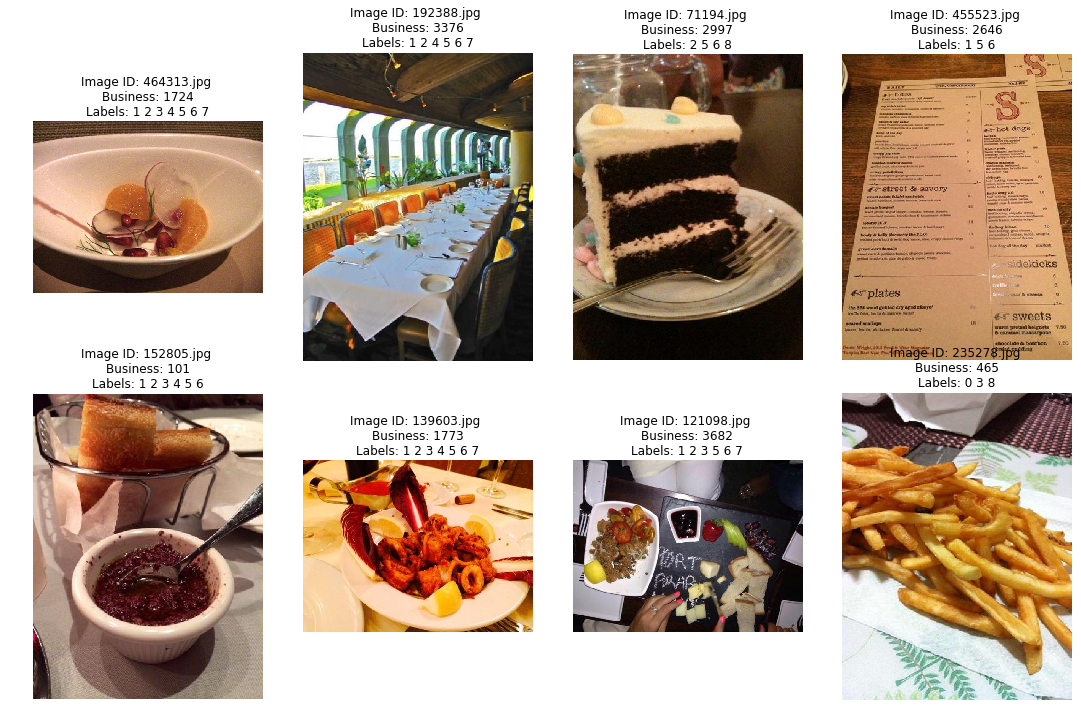

In [7]:
# Randomly sample 8 images
imgs_samples = random.sample(train_imgs, 8)

# Plot random sample of 8 images
plt.figure(figsize=(15, 10))
for i in range(len(imgs_samples)):
    # OpenCV2 reads images in BGR format
    img = cv2.imread(os.path.join(train_dir, imgs_samples[i]))
    
    # Switch color channels to RGB to make compatible with matplotlib imshow func
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Grab image's business ID and labels
    business = train_photo_to_id.loc[train_photo_to_id['photo_id'] == int(imgs_samples[i][:-4]), 'business_id']
    labels = train_data.loc[train_data['business_id'] == business.values[0], 'labels']
    
    # Annotate each image with image ID, business ID, and labels
    title = "Image ID: " + imgs_samples[i] + ' \nBusiness: ' + str(business.values[0]) + '\nLabels: ' + ''.join(labels.values)
    
    # Plot the image
    plt.subplot(2, 4, i+1)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    
plt.show()

### Image Shape Distribution

In [8]:
#Return shape of image (width, height channels)
def load_img_shapes(path_to_img):
    return cv2.imread(path_to_img).shape

In [9]:
# Initialize arrays to hold image sizes
train_shapes = []

# Load in training/testing image sizes
for i in range(len(train_imgs)):
    img_path = os.path.join(train_dir, train_imgs[i])
    train_shapes.append(load_img_shapes(img_path))

# Store training image sizes in dataframe
df_train = pd.DataFrame({'Shapes': train_shapes})
train_counts = df_train['Shapes'].value_counts()

print('Top Training Image Shapes')
for i in range(10):
    print("Shape %s counts: %d" % (train_counts.index[i], train_counts.values[i]))

Top Training Image Shapes
Shape (375, 500, 3) counts: 74512
Shape (500, 375, 3) counts: 74138
Shape (500, 500, 3) counts: 15478
Shape (281, 500, 3) counts: 10314
Shape (500, 373, 3) counts: 9463
Shape (373, 500, 3) counts: 9129
Shape (500, 281, 3) counts: 7120
Shape (333, 500, 3) counts: 6064
Shape (332, 500, 3) counts: 1614
Shape (282, 500, 3) counts: 1512


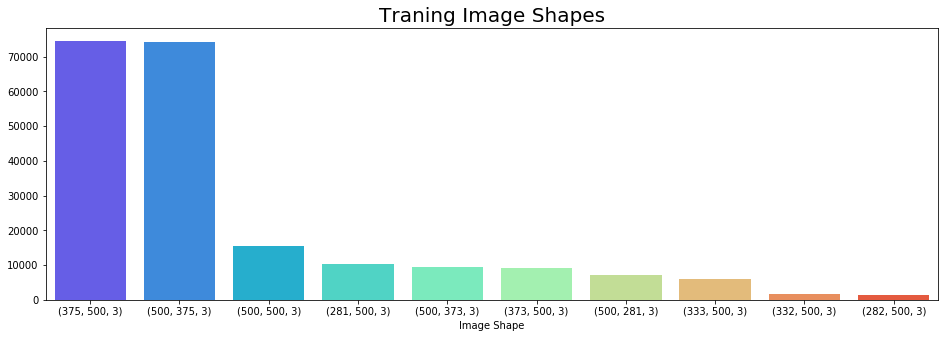

In [10]:
# Create barplot for image sizes distribution (training set)
x_train_plot = train_counts.index[:10]
x_train_plot = [str(x) for x in x_train_plot]
y_train_plot = train_counts.values[:10]

#Plot image shape distributions
x_bar_plot = sns.barplot(x_train_plot, y_train_plot, palette='rainbow')
x_bar_plot.figure.set_size_inches(16,5)
x_bar_plot.set_title('Traning Image Shapes', fontsize=20);
x_bar_plot.set(xlabel='Image Shape');
x_bar_plot.set_axis_bgcolor('white')

### Label Count Distribution

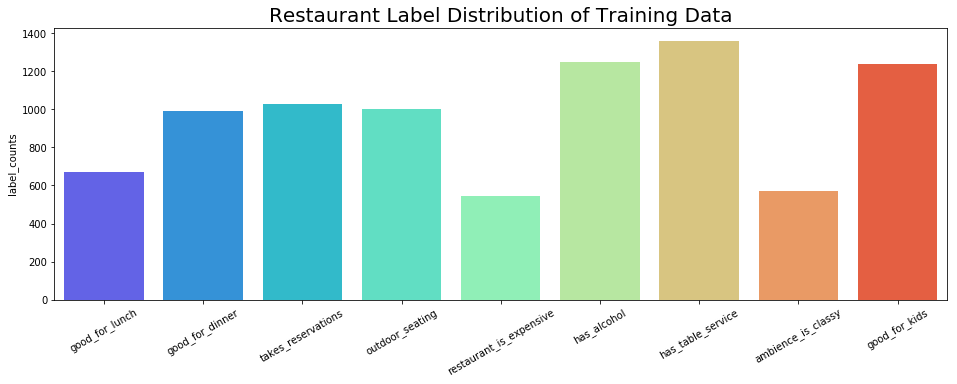

In [11]:
#Count all labels in training set
all_labels = ' '.join(list(train_data['labels'].fillna('nan').values)).split()
from collections import Counter
label_counts = Counter(all_labels)

#Create Dataframe of label counts
labels_df = pd.DataFrame([label_counts]).transpose()
labels_df.columns=['label_counts']
labels_df = labels_df.reset_index()
labels_df = labels_df.rename(columns={'index':'labels'})

#Create Dataframe of photo attributes
attributes = {0:'good_for_lunch', 
              1:'good_for_dinner',
              2:'takes_reservations',
              3:'outdoor_seating',
              4:'restaurant_is_expensive',
              5:'has_alcohol',
              6:'has_table_service',
              7:'ambience_is_classy',
              8:'good_for_kids',
             }

attributes_df = pd.DataFrame([attributes]).transpose()
attributes_df.columns=['attributes']
attributes_df = attributes_df.reset_index()
attributes_df = attributes_df.rename(columns={'index':'labels'})

#Add attributes to labels
labels_df['attributes'] = attributes_df.attributes

#Plot restaurant label distribution
x_bar_plot = sns.barplot(labels_df.attributes, labels_df.label_counts, palette='rainbow')
x_bar_plot.figure.set_size_inches(16,5)
x_bar_plot.set_title('Restaurant Label Distribution of Training Data', fontsize=20);
x_bar_plot.set_xlabel('')
x_bar_plot.set_xticklabels(x_bar_plot.get_xticklabels(),rotation=30)
x_bar_plot.set_axis_bgcolor('white')

plt.show()

In [12]:
#Verify labels dataframe
labels_df

,labels,label_counts,attributes
0,0,671,good_for_lunch
1,1,993,good_for_dinner
2,2,1026,takes_reservations
3,3,1003,outdoor_seating
4,4,547,restaurant_is_expensive
5,5,1249,has_alcohol
6,6,1360,has_table_service
7,7,572,ambience_is_classy
8,8,1238,good_for_kids
9,nan,4,NaN


# Model Preparation

In [13]:
#Create 'expensive' label for images
train_data['expensive'] = train_data.apply(lambda row: 1 if '4' in str(row['labels']) else 0, axis=1)
df = train_data.merge(train_photo_to_id,on='business_id')
display(df.head())

,business_id,labels,expensive,photo_id
0,1000,1 2 3 4 5 6 7,1,438623
1,1000,1 2 3 4 5 6 7,1,325966
2,1000,1 2 3 4 5 6 7,1,227692
3,1000,1 2 3 4 5 6 7,1,407856
4,1000,1 2 3 4 5 6 7,1,368729


### Model Experimentation Parameters

In [14]:
#Set Model Parameters
img_width = 224
img_height = 224
training_size = 1000
lr_set = 0.00005
epochs_set = 7
batch_set = 100
df_top = df.head(training_size)

### Data PreProcessing

In [15]:
#Create initial training dataset and size
int_X_train = []
int_y_train = []
files = glob.glob ('/Users/mac/Dropbox/Thinkful_Coursework/Course/Final_Capstone/train_photos/*.jpg')
count = 0

#Add expensive label to photo ids
for myFile in files:
    img = cv2.imread(myFile)
    img = cv2.resize(img,(img_width,img_height))
    int_X_train.append (img)
    
    fname = os.path.splitext(os.path.basename(myFile))[0]
    tmp_y_train = df.loc[df['photo_id'] == int(fname)]['expensive']
    int_y_train.append(tmp_y_train.iloc[0])
    
    count +=1

    if count%training_size == 0:
        break

### Train/Test Split

In [16]:
#Save indicies of training data
indices = np.array(df_top.index)

#Get train, test split 
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(int_X_train, int_y_train, indices, stratify=int_y_train , random_state=42)

#Convert class vectors to binary class matrices
y_train_origin = y_train
y_train = to_categorical(y_train, num_classes=2)

y_val_origin = y_val
y_val = to_categorical(y_val,num_classes=2)

#Verify length of training data
print('Length of y_train:', len(y_train))
print('Lenght of X_train:', len(X_train))
print('Length y_val:', len(y_val))

#Check for class imbalance in training data
cheap = np.bincount(int_y_train)[0]
expensive = np.bincount(int_y_train)[1]
y_expensive = expensive/(cheap+expensive)
y_cheap = cheap/(cheap+expensive)
print('Expensive Label is', round(y_expensive * 100,5), '% of the training dataset')
print('Cheap Label is', round(y_cheap * 100,5), '% of the training dataset')

Length of y_train: 750
Lenght of X_train: 750
Length y_val: 250
Expensive Label is 44.0 % of the training dataset
Cheap Label is 56.0 % of the training dataset


### Data Augmentation

In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train)

# Build Models

### Basic CNN Model

In [20]:
#Build Basic Conv2D
basic_cnn_model = Sequential()
basic_cnn_model.add(Conv2D(32, (3, 3), input_shape=(3, img_width, img_height)))
basic_cnn_model.add(Activation('relu'))
basic_cnn_model.add(Flatten()) 
basic_cnn_model.add(Dense(2))
model.add(Activation('softmax'))

#Compile Con2D
basic_cnn_model.compile(Adam(lr=lr_set), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

#Fit Conv2D with data augmentation
datagen.fit(X_train)
basic_cnn_model.fit_generator(datagen.flow(np.array(X_train), np.array(y_train), batch_size=batch_set), 
                        steps_per_epoch=np.array(X_train).shape[0], 
                        epochs=epochs_set, 
                        validation_data=(np.array(X_val), np.array(y_val)))

#Get Basic CNN Model Accuracy
evaluation_basic_cnn_model = basic_cnn_model.evaluate(np.array(X_val),np.array(y_val))
print("basic_cnn:{}".format(evaluation_basic_cnn_model))

Epoch 1/7
750/750 [==============================] - 3270s 4s/step - loss: 0.6899 - acc: 0.6223 - val_loss: 6.7766 - val_acc: 0.5760
Epoch 2/7
750/750 [==============================] - 3266s 4s/step - loss: 0.6104 - acc: 0.6694 - val_loss: 6.0810 - val_acc: 0.6120
Epoch 3/7
750/750 [==============================] - 3343s 4s/step - loss: 0.5795 - acc: 0.6937 - val_loss: 6.5471 - val_acc: 0.5880
Epoch 4/7
750/750 [==============================] - 3449s 5s/step - loss: 0.5688 - acc: 0.7010 - val_loss: 6.2514 - val_acc: 0.6000
Epoch 5/7
750/750 [==============================] - 3458s 5s/step - loss: 0.5615 - acc: 0.7073 - val_loss: 6.2341 - val_acc: 0.6080
Epoch 6/7
750/750 [==============================] - 3174s 4s/step - loss: 0.5545 - acc: 0.7119 - val_loss: 6.1736 - val_acc: 0.6120
Epoch 7/7
250/250 [==============================] - 4s 15ms/step
basic_cnn:[6.266907279968262, 0.6040000023841858]


### Complex CNN Model

In [23]:
#Buiild Complex Conv2D
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(img_width,img_height,3),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model


#Compile Complex Conv2D
complex_cnn_model = cnn_model()
sgd = SGD(lr=lr_set, decay=1e-6, momentum=0.9, nesterov=True)
complex_cnn_model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#Fit Complex Conv2D
complex_cnn_model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_set,
          epochs=epochs_set,
          validation_split=0.2,)

Train on 600 samples, validate on 150 samples
Epoch 1/7
600/600 [==============================] - 270s 450ms/step - loss: 7.1458 - acc: 0.4617 - val_loss: 6.8533 - val_acc: 0.5667
Epoch 2/7
600/600 [==============================] - 262s 437ms/step - loss: 5.7884 - acc: 0.5750 - val_loss: 3.3520 - val_acc: 0.6267
Epoch 3/7
600/600 [==============================] - 262s 436ms/step - loss: 5.9099 - acc: 0.5417 - val_loss: 2.4771 - val_acc: 0.5800
Epoch 4/7
600/600 [==============================] - 262s 436ms/step - loss: 6.0951 - acc: 0.5583 - val_loss: 5.7196 - val_acc: 0.5667
Epoch 5/7
600/600 [==============================] - 260s 433ms/step - loss: 5.7978 - acc: 0.5300 - val_loss: 1.4333 - val_acc: 0.5533
Epoch 6/7
600/600 [==============================] - 261s 435ms/step - loss: 3.7177 - acc: 0.5817 - val_loss: 0.9887 - val_acc: 0.5733
Epoch 7/7
600/600 [==============================] - 257s 429ms/step - loss: 2.3354 - acc: 0.5733 - val_loss: 0.7590 - val_acc: 0.5000


In [24]:
#Get Complex CNN Model Accuracy
evaluation_complex_cnn_model = complex_cnn_model.evaluate(np.array(X_val),np.array(y_val))
print("basic_cnn:{}".format(evaluation_complex_cnn_model))

250/250 [==============================] - 30s 119ms/step
basic_cnn:[0.7757818999290467, 0.48800000286102296]


### Pre-Trained Models

In [25]:
def model(X_train, y_train, X_val, y_val, base_model):

    # get layers and add average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # add fully-connected layer
    x = Dense(512, activation='relu')(x)

    # add output layer
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    # freeze pre-trained model area's layer
    for layer in base_model.layers:
        layer.trainable = False

    # update the weight that are added
    model.compile(Adam(lr=lr_set), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
                  
    model.fit(X_train, y_train)

    # choose the layers which are updated by training
    layer_num = len(model.layers)
    for layer in model.layers[:int(layer_num * 0.9)]:
        layer.trainable = False

    for layer in model.layers[int(layer_num * 0.9):]:
        layer.trainable = True

    # update the weights
    model.compile(Adam(lr=lr_set), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs_set)
    return history


res_50_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_shape=(img_width, img_height,3))

vgg_19_model = VGG19(weights='imagenet', 
                     include_top=False, 
                     input_shape=(img_width, img_height,3))

vgg_16_model = VGG16(weights='imagenet', 
                     include_top=False, 
                     input_shape=(img_width, img_height, 3))


history_res_50 = model(np.array(X_train), 
                       np.array(y_train), 
                       np.array(X_val),
                       np.array(y_val),
                       res_50_model)

history_vgg_19 = model(np.array(X_train), 
                       np.array(y_train), 
                       np.array(X_val),
                       np.array(y_val),
                       vgg_19_model)

history_vgg_16 = model(np.array(X_train), 
                       np.array(y_train), 
                       np.array(X_val),
                       np.array(y_val),
                       vgg_16_model)

Epoch 1/1
750/750 [==============================] - 273s 365ms/step - loss: 0.6863 - acc: 0.6107
Train on 750 samples, validate on 250 samples
Epoch 1/7
750/750 [==============================] - 967s 1s/step - loss: 0.5579 - acc: 0.7253 - val_loss: 0.6420 - val_acc: 0.6520
Epoch 2/7
750/750 [==============================] - 948s 1s/step - loss: 0.1146 - acc: 0.9907 - val_loss: 0.6696 - val_acc: 0.6640
Epoch 3/7
750/750 [==============================] - 957s 1s/step - loss: 0.0374 - acc: 1.0000 - val_loss: 0.6875 - val_acc: 0.6960
Epoch 4/7
750/750 [==============================] - 969s 1s/step - loss: 0.0187 - acc: 1.0000 - val_loss: 0.7227 - val_acc: 0.6760
Epoch 5/7
750/750 [==============================] - 1003s 1s/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.7451 - val_acc: 0.6760
Epoch 6/7
750/750 [==============================] - 1005s 1s/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.7791 - val_acc: 0.6720
Epoch 7/7
750/750 [==============================] - 991s 1s/s

In [26]:
#Check Model Accuracy on Validation Data
evaluation_res_50 = history_res_50.model.evaluate(np.array(X_val),np.array(y_val))
evaluation_vgg_19 = history_vgg_19.model.evaluate(np.array(X_val),np.array(y_val))
evaluation_vgg_16 = history_vgg_16.model.evaluate(np.array(X_val),np.array(y_val))

print("res_50:{}".format(evaluation_res_50))
print("vgg_19:{}".format(evaluation_vgg_19))
print("vgg_16:{}".format(evaluation_vgg_16))

250/250 [==============================] - 172s 688ms/step
res_50:[0.7917018518447876, 0.6640000028610229]
vgg_19:[0.796748254776001, 0.6679999990463257]
vgg_16:[0.7657797689437866, 0.6640000019073486]


# Evaluate Models

### Confusion Matrix

In [33]:
#Get Predictions for Built Models
y_pred_cnn_basic = basic_cnn_model.predict(np.array(X_val))
y_pred_cnn_complex = complex_cnn_model.predict(np.array(X_val))

#Get Predictions for Pre-Trained Models
y_pred_res_50 = history_res_50.model.predict(np.array(X_val))
y_pred_vgg19 = history_vgg_19.model.predict(np.array(X_val))
y_pred_vgg16 = history_vgg_16.model.predict(np.array(X_val))

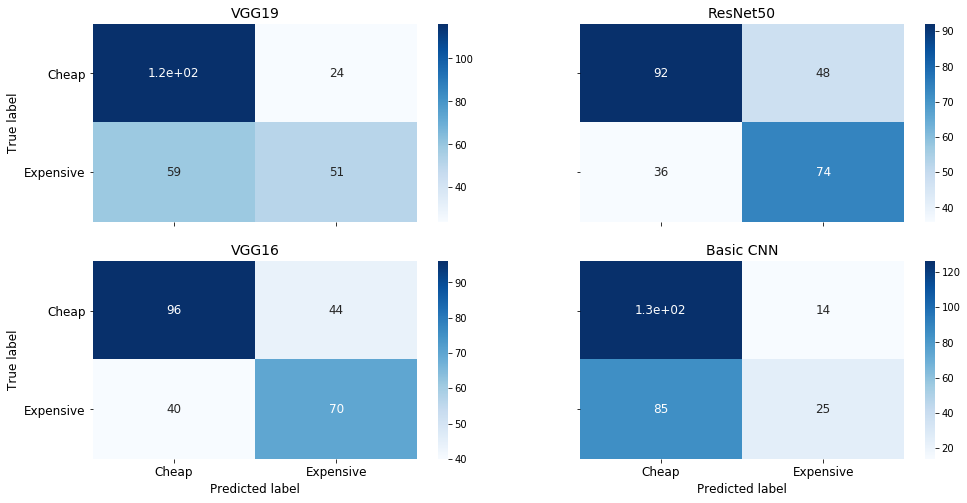

In [34]:
#Setup Confusion Matrix Plots
fig, ax = plt.subplots(2, 2,figsize=(16,8))
labels = ['Cheap', 'Expensive']

#Transform Labels to Vectors
y_pred_res_50 = np.argmax(y_pred_res_50, axis=1)
y_pred_vgg19 = np.argmax(y_pred_vgg19, axis=1)
y_pred_vgg16 = np.argmax(y_pred_vgg16, axis=1)
y_pred_cnn_basic = np.argmax(y_pred_cnn_basic, axis=1)

#Build Confusion Maxtrices
cm_res_50 = confusion_matrix(y_val_origin, y_pred_res_50)
cm_vgg19 = confusion_matrix(y_val_origin, y_pred_vgg19)
cm_vgg16 = confusion_matrix(y_val_origin, y_pred_vgg16)
cm_cnn_basic = confusion_matrix(y_val_origin, y_pred_cnn_basic)

#VGG19 Model Confusion Matrix
sns.heatmap(cm_vgg19, ax=ax[0][0], annot=True, annot_kws={"size": 12}, cmap=plt.cm.Blues)
ax[0][0].set_title("VGG19", fontsize=14)
ax[0][0].set_xticklabels(['', ''], fontsize=12)
ax[0][0].set_yticklabels(['Cheap', 'Expensive'], fontsize=12, rotation=360)
ax[0][0].set_ylabel('True label', fontsize=12)

#ResNet50 Model Confusion Matrix
sns.heatmap(cm_res_50 , ax=ax[0][1], annot=True, annot_kws={"size": 12}, cmap=plt.cm.Blues)
ax[0][1].set_title("ResNet50", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=12, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=12, rotation=360)

#VGG16 Model Confusion Matrix
sns.heatmap(cm_vgg16, ax=ax[1][0], annot=True, annot_kws={"size": 12}, cmap=plt.cm.Blues)
ax[1][0].set_title("VGG16", fontsize=14)
ax[1][0].set_xticklabels(['Cheap', 'Expensive'], fontsize=12)
ax[1][0].set_yticklabels(['Cheap', 'Expensive'], fontsize=12, rotation=360)
ax[1][0].set_xlabel('Predicted label', fontsize=12)
ax[1][0].set_ylabel('True label', fontsize=12)

#Basic CNN Model Confusion Matrix
sns.heatmap(cm_cnn_basic, ax=ax[1][1], annot=True, annot_kws={"size": 12}, cmap=plt.cm.Blues)
ax[1][1].set_title("Basic CNN", fontsize=14)
ax[1][1].set_xticklabels(['Cheap', 'Expensive'], fontsize=12)
ax[1][1].set_yticklabels(['', ''], fontsize=12, rotation=360)
ax[1][1].set_xlabel('Predicted label', fontsize=12)

plt.show()

### Classification Reports

In [ ]:
print ('\nClassification Report: ResNet50\n', classification_report(y_val_origin, y_pred_res_50))
print('__' *28)
print ('\nClassification Report: VGG19\n', classification_report(y_val_origin, y_pred_vgg19))
print('__' *28)
print ('\nClassification Report: VGG16\n', classification_report(y_val_origin, y_pred_vgg16))
print('__' *28)
print ('\nClassification Report: Basic CNN\n', classification_report(y_val_origin, y_pred_cnn_basic))

# Validate Model

### Image Plot Preparation

In [40]:
y_val_final = np.argmax(y_val, axis=1)

In [41]:
indices_lookup = pd.DataFrame(indices_val).reset_index()
indices_lookup.columns=['final_index', 'original_index']

In [42]:
model_check = y_pred_res_50

def rand_by_df(col):
    return indices_lookup[indices_lookup.final_index.isin(col)].original_index.values

def rand_by_mask(mask): 
    return rand_by_df(np.random.choice(np.where(mask)[0], 4, replace=False))

def rand_by_correct(is_correct): 
    results = model_check == y_val_final
    return rand_by_mask((results)==is_correct)

In [43]:
def plots(ims, figsize=(6,3), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title('Predicted Label: {}' .format(titles[i]), fontsize=14)
            plt.imshow(ims[i])   

In [44]:
model_check = y_pred_res_50

PATH='/Users/mac/Dropbox/Thinkful_Coursework/Course/Final_Capstone/train_photos/'

def load_img_id(df, idx):
    filepath = PATH+str(df.photo_id[idx]) +'.jpg' 
    img = cv2.imread(filepath)
    img = cv2.resize(img,(img_width,img_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(df, x) for x in idxs]
    idxs_final = list(indices_lookup[indices_lookup.original_index.isin(idxs)].final_index.values)
    title_probs = [model_check[x] for x in idxs_final]
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

### Correctly Classified Images

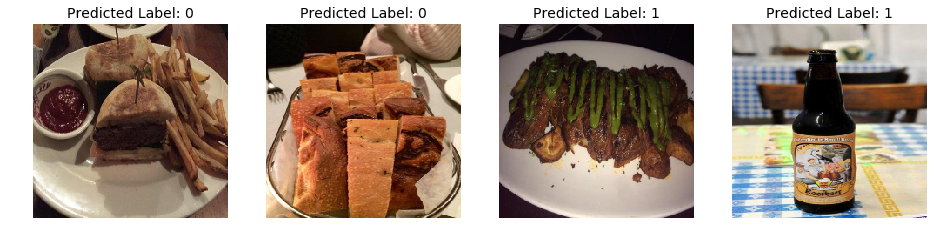

In [45]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

### Incorrectly Classified Images

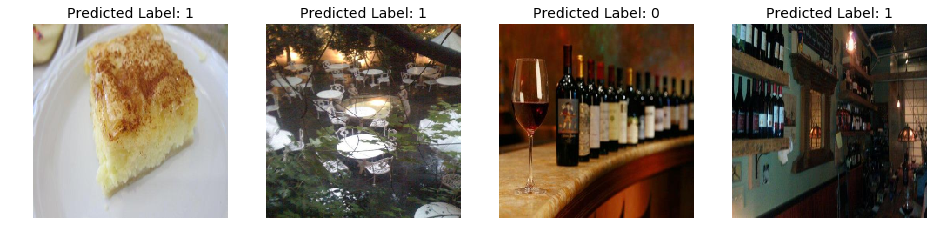

In [46]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [47]:
# y_pred_res_50 = np.argmax(y_pred_res_50)
probs = history_res_50.model.predict(np.array(X_val))
probs= probs[:,1] 

In [48]:
probs[0:10]

array([1.8973915e-01, 7.2186297e-01, 3.1176227e-01, 3.0326360e-01,
       2.4005535e-01, 9.9946994e-01, 8.6301737e-02, 6.3561857e-02,
       3.9259484e-01, 4.0464965e-04], dtype=float32)

In [86]:
model_check = y_pred_res_50

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * model_check[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    results = model_check == y_val_final
    return most_by_mask(((results)==is_correct) & (y_val_final == y), mult)

def plots_2(ims, figsize=(6,3), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title('Predicted Probability: \n{} %' .format(round(titles[i]*100,2)), fontsize=14)
            plt.imshow(ims[i])  
                    
def plot_val_with_title_2(idxs, title):
    original_indxs=indices_lookup[indices_lookup.final_index.isin(idxs)].original_index.values
    imgs = [load_img_id(df, x) for x in original_indxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots_2(imgs, figsize=(16, 8), rows=1, titles=title_probs) 

### Most Correct Expensive Classified Images

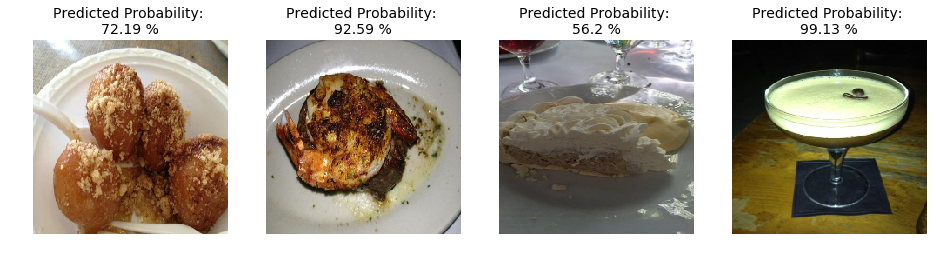

In [87]:
plot_val_with_title_2(most_by_correct(1, True), " ")

### Most Correct Cheap Classified Images

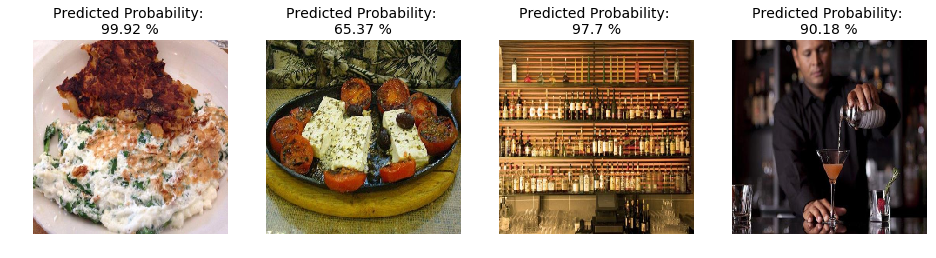

In [88]:
plot_val_with_title_2(most_by_correct(0, False), " ")

### Most Incorrect Expensive Classified Images

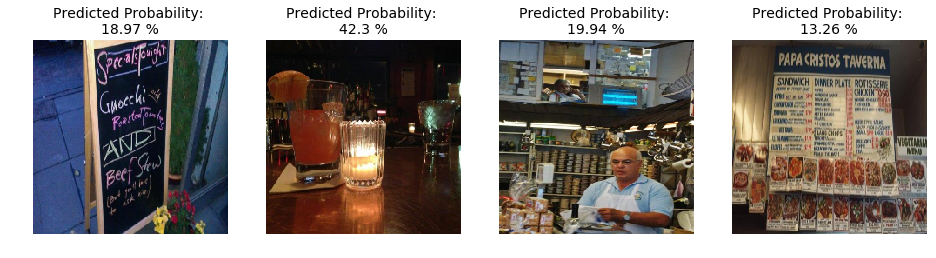

In [91]:
plot_val_with_title_2(most_by_correct(1, False), " ")

### Most Incorrect Cheap Classified Images

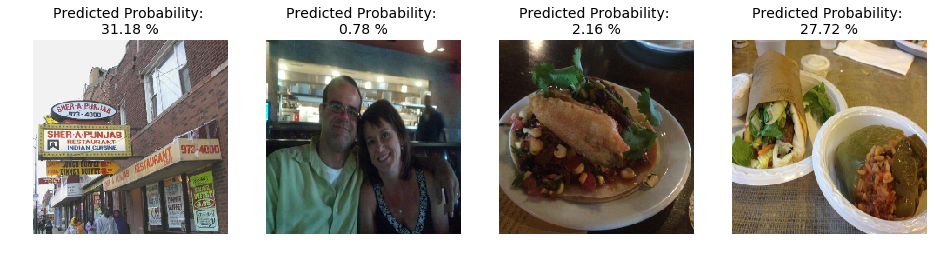

In [92]:
plot_val_with_title_2(most_by_correct(0, True), " ")

# Conclusion

* My analysis included the development of five different models, which included two custom Convolutional Neural Networks (CNN) and three pre-trained models.   

#### Custom Model Performance
* The two customs CNNs included a simple (or basic) model with few layers and a more complex model with several layers.  Of the these two models, the simple CNN unexpectedly outperformed the complex CNN, showing a model accuracy of 60% compared to only 48% for the more complex model.  

#### Pre-Trained Model Performance
* The three pre-trained models used in this analysis were as follows:  **VGG16, VGG19 and ResNet50**.  
* The accuracy of these of models were very similar, with the ResNet50 slightly outperforming the other two models with a score of 67% compared to 66% each for the VGG models.  
* However, the VGG19 model had the highest precision on the expensive class (Label 1), displaying a score of 68% compared to 61% both the ResNet50 and VGG16 models. 
* On the other hand, the ResNet 50 displayed the highest precison on the cheap class (Label 0).

#### Winning Model - ResNet50
* In my final analysis, I determined that ResNet 50 model was the winning model, given its consistent peformance across classes and all classification metrics.  
* However, there are some concerns with overfitting that need to be addressed.  This is because the ResNet 50 model displayed a 100% accuracy score on the traning data, but only a 67% score on the validation data.  

# Next Steps

#### Image Augmentation
* Although the ResNet50 was the most accurate model, it seemed to overfit quite a bit, training to the noise included in training photos.  To combat this, image augmentation can be implemented with the ResNet50 model.  This will ensure that the model will never see the same exact image twice. This helps prevent overfitting and helps the model generalize better. 

#### More Experimentation
* I utilized the Keras optimizer - Adam - when modifying the pre-trained ResNet50 model.  However, it will be useful to leverage other optimizers, such as the Stochastic gradient descent (SGD), RMSProp and Adagrad optimizers. 
* I can try Max pooling instead of Averaging pooling to get more extreme features from training images.
* Additionally, I can experiment with different learning rates and more epochs to improve model performance.
 

#### Integrate NLP
* Once I have improved the performance of the model with image augmentation and other optimization techniques, I would like to integrate Natural Language Processing (NLP).  
* Possible uses of NLP could be to peform sentiment analysis and/or summary analysis on the reviews provided by Yelp users when they add photos to the website.

### Pre-Trained Models with Image Augmentation

# def model(X_train, y_train, X_val, y_val, base_model):

    # get layers and add average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # add fully-connected layer
    x = Dense(512, activation='relu')(x)

    # add output layer
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    # freeze pre-trained model area's layer
    for layer in base_model.layers:
        layer.trainable = False

    # update the weight that are added
    model.compile(Adam(lr=lr_set), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
                  
    model.fit(X_train, y_train)

    # choose the layers which are updated by training
    layer_num = len(model.layers)
    for layer in model.layers[:int(layer_num * 0.9)]:
        layer.trainable = False

    for layer in model.layers[int(layer_num * 0.9):]:
        layer.trainable = True

    # update the weights
    model.compile(Adam(lr=lr_set), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_set), 
                        steps_per_epoch=X_train.shape[0], 
                        epochs=epochs_set, 
                        validation_data=(X_val, y_val))   
    
    return history


res_50_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_shape=(img_width, img_height,3))


history_res_50 = model(np.array(X_train), 
                       np.array(y_train), 
                       np.array(X_val),
                       np.array(y_val),
                       res_50_model)

In [ ]:
#Check ResNet 50 with Augmentation Model Accuracy on Validation Data
evaluation_res_50_aug = history_res_50.model.evaluate(np.array(X_val),np.array(y_val))
print("res_50_aug:{}".format(evaluation_res_50))